<a href="https://colab.research.google.com/github/meganross17/Ross-606-Project-NYC311Calls/blob/main/Ross_DATA606Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone DATA 606 Project**: NYC 311 service requests 
## By: Megan Ross


# Introduction



**The dataset: NYC Open Data 311 Service Requests**

*   311 is a non-emergency phone number that allows callers to report problems, access municipal services, and request information
*   Dataset is automatically updated daily, was made public in Oct 2011
*   Each row is a 311-service request
*   Individuals can call these requests in or log them online/via mobile devices


*   Link: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9






My goal using the NYC 311 dataset was to see if I can create a model that could predict response times for various calls and complaints. To do this, I have to create columns that represent the response time (date created vs. date closed). Other key feautures included in my analysis include borough, complaint type, and responding agency. Based on the size of the dataset, I've decided to only include records from 2020 with a status=closed so I can create the response time column.  

## Import Packages

In [1]:
!pip install sodapy # sodapy- python socrata client 
!pip install pmdarima #pmd arima 

import matplotlib as mpl
from matplotlib import pyplot as plt

     |████████████████████████████████| 1.5MB 9.7MB/s 
     |████████████████████████████████| 9.5MB 26.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Load Data 

*   Load data from Socrata (Socrata Open Data (SODA)) API partners with NYC Open Data to host City data
*   Source: https://holowczak.com/getting-started-with-nyc-opendata-and-the-socrata-api/5/

### Data critera: 

*   Selected data that was created in 2020 and the ticket status is closed
*   The limit in the below is how many recent rows do you want






In [2]:
%%time

from sodapy import Socrata
import pandas as pd

client = Socrata("data.cityofnewyork.us", None)
# Set the timeout in seconds
client.timeout = 360
# Limit = how many rows should we pull? (Starts from most recent and works back)
results = client.get("erm2-nwe9", 
                     select="created_date, closed_date, agency, complaint_type, descriptor, status, borough, unique_key, Open_Data_Channel_Type",
                     order="created_date DESC", where="created_date > '2020' AND created_date < '2021' AND status = 'Closed'",
                     limit = 3000000)
df1 = pd.DataFrame.from_records(results)

CPU times: user 15.7 s, sys: 2.9 s, total: 18.6 s
Wall time: 2min 48s


# Descriptive statistics, sample data, & column creation

In [3]:
# How many rows of data did we import?
print(df1.shape)

(2488359, 9)


In [4]:
df1.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488359 entries, 0 to 2488358
Data columns (total 9 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   created_date            object
 1   closed_date             object
 2   agency                  object
 3   complaint_type          object
 4   descriptor              object
 5   status                  object
 6   borough                 object
 7   unique_key              object
 8   Open_Data_Channel_Type  object
dtypes: object(9)
memory usage: 1.4 GB


In [5]:
# Descriptive statistics of the data
df1.describe()

,created_date,closed_date,agency,complaint_type,descriptor,status,borough,unique_key,Open_Data_Channel_Type
count,2488359,2488357,2488359,2488359,2485171,2488359,2463453,2488359,2488359
unique,2082913,1755291,16,175,854,1,6,2488359,5
top,2020-08-31T12:00:00.000,2020-08-04T12:00:00.000,NYPD,Noise - Residential,Loud Music/Party,Closed,BROOKLYN,47180234,ONLINE
freq,162,1202,1269236,407045,511356,2488359,701197,1,883505


In [6]:
# Column names
df1.columns

Index(['created_date', 'closed_date', 'agency', 'complaint_type', 'descriptor',
       'status', 'borough', 'unique_key', 'Open_Data_Channel_Type'],
      dtype='object')

In [7]:
# Sample the data
df1.sample(5)

,created_date,closed_date,agency,complaint_type,descriptor,status,borough,unique_key,Open_Data_Channel_Type
2437797,2020-01-10T15:39:21.000,2020-01-10T23:44:27.000,NYPD,Panhandling,N/A,Closed,MANHATTAN,45359693,ONLINE
2465469,2020-01-05T16:16:50.000,2020-01-05T22:37:40.000,NYPD,Illegal Parking,Blocked Hydrant,Closed,QUEENS,45318593,PHONE
1953880,2020-04-18T19:05:09.000,2020-04-23T17:55:48.000,HPD,HEAT/HOT WATER,APARTMENT ONLY,Closed,BRONX,46023177,PHONE
462296,2020-10-23T06:43:32.000,2020-10-23T06:47:16.000,NYPD,Noise - Street/Sidewalk,Loud Talking,Closed,BRONX,47953872,ONLINE
2261505,2020-02-14T10:25:36.000,2020-02-14T11:46:05.000,NYPD,Panhandling,N/A,Closed,MANHATTAN,45618132,ONLINE


**Complaint_type** is the fist level of a hierarchy identifying the topic of the incident or condition. Complaint Type *may* have a corresponding **Descriptor** or may stand alone.


In [8]:
# First and last day of data
df1[['created_date', 'closed_date']] = df1[['created_date', 'closed_date']].apply(pd.to_datetime)

print('Initial_Retrieved_date:',df1['created_date'].max())
print('Final_Retrieved_date:',df1['closed_date'].min())

Initial_Retrieved_date: 2020-12-31 23:59:55
Final_Retrieved_date: 2020-01-01 00:03:35


## Creating new columns

Create a new column date_diff where I calculate the time between when the complaint was entered and when it was closed. I looked at date_diff in days, hours, and seconds. 


In [9]:
# Create column with the difference of the dates a ticket was closed and open.
from datetime import timedelta
import numpy as np

df1[['created_date', 'closed_date']] = df1[['created_date', 'closed_date']].apply(pd.to_datetime)
df1[["created_dd_mm_yyyy"]]=df1.created_date.map(lambda x: x.strftime('%Y-%m-%d'))
df1["hour"]=pd.DatetimeIndex(df1["created_date"]).hour
df1["month"] = pd.DatetimeIndex(df1["created_date"]).month
df1['date_diff'] = df1['closed_date'] - df1['created_date']
df1['date_diff_sec'] = df1['date_diff'].dt.total_seconds()
df1["date_diff_hours"] = round(df1["date_diff_sec"]/3600, 1)

In [10]:
# Shape with new columns added
print(df1.shape)

(2488359, 15)


In [11]:
# Taking a look at the data
df1.sample(10)

,created_date,closed_date,agency,complaint_type,descriptor,status,borough,unique_key,Open_Data_Channel_Type,created_dd_mm_yyyy,hour,month,date_diff,date_diff_sec,date_diff_hours
2444445,2020-01-09 12:42:53,2020-03-02 15:28:45,TLC,Taxi Complaint,Driver Complaint - Passenger,Closed,QUEENS,45344973,PHONE,2020-01-09,12,1,53 days 02:45:52,4589152.0,1274.8
1055800,2020-08-09 23:03:00,2020-08-10 00:40:00,DOT,Traffic Signal Condition,Controller,Closed,BROOKLYN,47180747,UNKNOWN,2020-08-09,23,8,0 days 01:37:00,5820.0,1.6
562917,2020-10-09 09:49:32,2020-10-09 10:58:42,DOT,Sidewalk Condition,Broken Sidewalk,Closed,QUEENS,47830377,MOBILE,2020-10-09,9,10,0 days 01:09:10,4150.0,1.2
1804681,2020-05-16 15:23:15,2020-05-16 15:29:16,NYPD,Non-Emergency Police Matter,Social Distancing,Closed,BROOKLYN,46212528,ONLINE,2020-05-16,15,5,0 days 00:06:01,361.0,0.1
1689210,2020-06-02 19:48:31,2020-06-02 19:51:37,NYPD,Illegal Parking,Posted Parking Sign Violation,Closed,BROOKLYN,46365645,PHONE,2020-06-02,19,6,0 days 00:03:06,186.0,0.1
2313610,2020-02-03 22:15:30,2020-02-21 09:13:03,HPD,UNSANITARY CONDITION,MOLD,Closed,BROOKLYN,45533000,ONLINE,2020-02-03,22,2,17 days 10:57:33,1508253.0,419.0
1168536,2020-07-31 11:12:52,2020-07-31 11:12:52,DOHMH,Unsanitary Animal Pvt Property,Dog,Closed,MANHATTAN,47047762,PHONE,2020-07-31,11,7,0 days 00:00:00,0.0,0.0
1175319,2020-07-30 12:03:41,2020-07-30 18:29:14,DHS,Homeless Person Assistance,N/A,Closed,MANHATTAN,47033428,MOBILE,2020-07-30,12,7,0 days 06:25:33,23133.0,6.4
247791,2020-11-22 16:55:40,2021-04-17 00:00:00,DOB,General Construction/Plumbing,Building Permit - None,Closed,BROOKLYN,48223614,UNKNOWN,2020-11-22,16,11,145 days 07:04:20,12553460.0,3487.1
1602006,2020-06-15 05:48:49,2020-06-15 06:03:26,NYPD,Noise - Residential,Loud Music/Party,Closed,MANHATTAN,46490121,ONLINE,2020-06-15,5,6,0 days 00:14:37,877.0,0.2


In [12]:
# Column names
print(df1.columns)

Index(['created_date', 'closed_date', 'agency', 'complaint_type', 'descriptor',
       'status', 'borough', 'unique_key', 'Open_Data_Channel_Type',
       'created_dd_mm_yyyy', 'hour', 'month', 'date_diff', 'date_diff_sec',
       'date_diff_hours'],
      dtype='object')


# Data Cleaning
There are many complaint types but some of them are not intelligible, to rectify this I looked at how many times each complaint was logged

In [13]:
# MAYORS OFFICE OF SPECIAL ENFORCEMENT shows up with symbols and is a long name for visualizations when all the other agencies are abreviations
df1['agency'] = df1['agency'].str.replace('MAYORâS OFFICE OF SPECIAL ENFORCEMENT', 'MAYORS OFFICE')

In [14]:
# Get unique complaint types
df_unique = df1['complaint_type'].value_counts()
# Look at count of unique complaint types
print(df_unique.shape) 

(175,)


In [15]:
# Drop complaint types with a value count of less than or equal to 5 (messy data). These are the complaint types that have hardly been used. 
value_counts = df1['complaint_type'].value_counts()
to_remove = value_counts[value_counts <= 5].index 

df1.drop(df1[df1['complaint_type'].isin(to_remove)].index, inplace = True)

df_unique = df1['complaint_type'].value_counts()
print(df_unique.shape)

(155,)


In [16]:
# An array of unique complaint types to see the variety of what these look like
complaints=df1['complaint_type'].unique()
complaints

array(['Noise - Vehicle', 'Homeless Street Condition',
       'Noise - Residential', 'Blocked Driveway', 'Noise - Helicopter',
       'HEAT/HOT WATER', 'NonCompliance with Phased Reopening',
       'Illegal Fireworks', 'Lead', 'Illegal Parking',
       'Sanitation Condition', 'Noise - Commercial', 'Sewer',
       'Noise - Street/Sidewalk', 'Street Condition',
       'Mass Gathering Complaint', 'Non-Emergency Police Matter',
       'Street Sign - Damaged', 'Street Sign - Dangling',
       'Abandoned Vehicle', 'Consumer Complaint', 'Drug Activity',
       'Noise - House of Worship', 'Traffic Signal Condition',
       'Water System', 'Noise', 'UNSANITARY CONDITION', 'Rodent',
       'PLUMBING', 'Sidewalk Condition', 'APPLIANCE', 'Drinking',
       'Street Light Condition', 'Water Quality',
       'Emergency Response Team (ERT)', 'WATER LEAK', 'Building/Use',
       'General Construction/Plumbing', 'GENERAL', 'Elevator', 'Traffic',
       'ELECTRIC', 'PAINT/PLASTER', 'Lost Property', 'Anim

Taking a look at null & missing values

created_date                  0
closed_date                   2
agency                        0
complaint_type                0
descriptor                 3188
status                        0
borough                   24906
unique_key                    0
Open_Data_Channel_Type        0
created_dd_mm_yyyy            0
hour                          0
month                         0
date_diff                     2
date_diff_sec                 2
date_diff_hours               2
dtype: int64

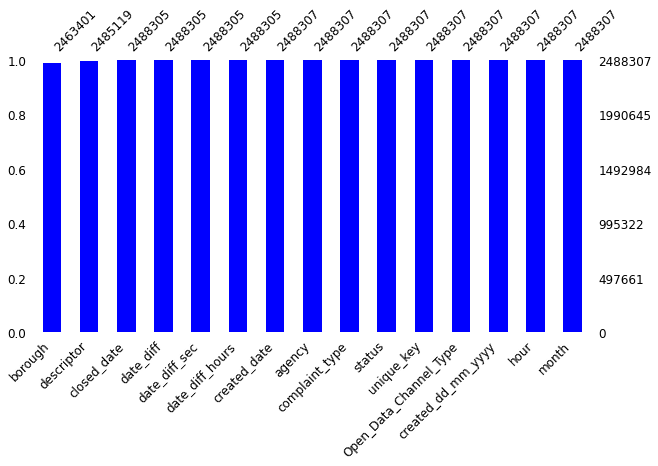

In [17]:
# Missing Values
import missingno as msno
msno.bar(df1, color="blue", sort="ascending", figsize=(10,5), fontsize=12)
df1.isnull().sum()

In [18]:
# Drop the nulls since it will not drop a significant amount of data
df1 = df1.dropna()

Check for duplicate records

In [19]:
duplicate= df1.duplicated()
print(duplicate.sum())
df1[duplicate]

0


,created_date,closed_date,agency,complaint_type,descriptor,status,borough,unique_key,Open_Data_Channel_Type,created_dd_mm_yyyy,hour,month,date_diff,date_diff_sec,date_diff_hours


# Visualizations 


## High-level visualizations

Taking a look at the count of calls over the entire year 2020

Text(0.5, 0, 'Date')

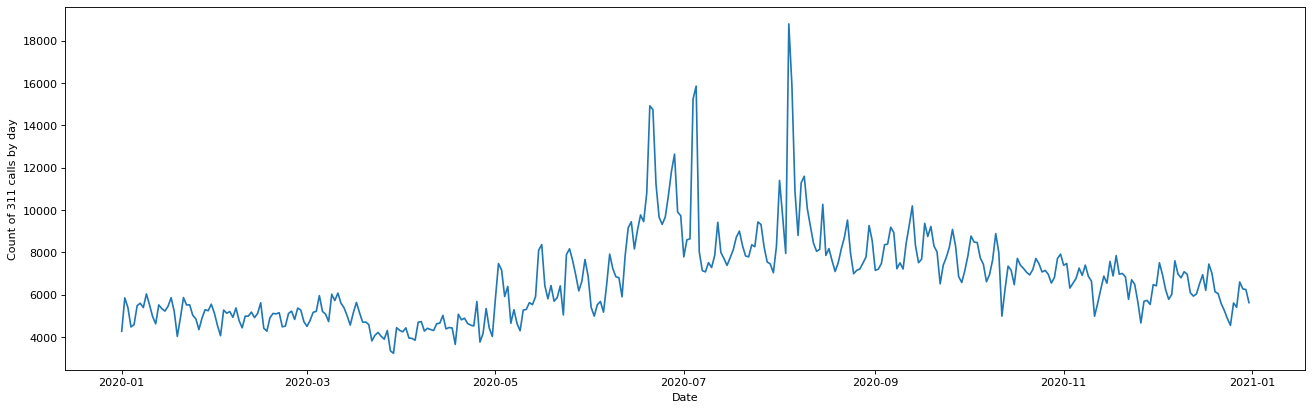

In [20]:
#Number of 311 calls made per day in 2020.
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
dfLine = df1['month'].groupby(df1.created_date.dt.date).count()

ax = dfLine.plot.line()
ax.set_ylabel("Count of 311 calls by day")
ax.set_xlabel("Date")

In [21]:
# Days with highest number of complaints logged
print("Days with highest number of complaints")
df1.created_dd_mm_yyyy.value_counts().nlargest(10)

Days with highest number of complaints


2020-08-04    18789
2020-08-05    15893
2020-07-05    15848
2020-07-04    15238
2020-06-20    14917
2020-06-21    14739
2020-06-28    12636
2020-06-27    11825
2020-08-09    11592
2020-08-01    11394
Name: created_dd_mm_yyyy, dtype: int64

In [22]:
# Days with lowest number of complaints logged
print("Days with lowest number of complaints")
df1.created_dd_mm_yyyy.value_counts().nsmallest(10)

Days with lowest number of complaints


2020-03-29    3231
2020-03-28    3350
2020-04-18    3649
2020-04-26    3762
2020-03-22    3816
2020-04-05    3849
2020-03-26    3898
2020-04-04    3933
2020-04-03    3954
2020-04-30    4026
Name: created_dd_mm_yyyy, dtype: int64

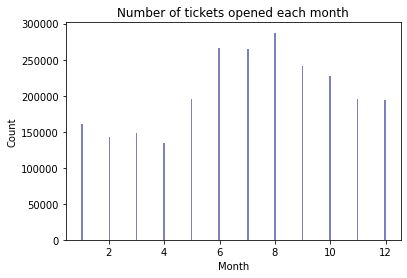

In [23]:
# Histogram to visualize most repeated month
num_bins = 200
data_value=df1['month']
plt.hist(data_value, num_bins, facecolor='navy', alpha=0.5)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Number of tickets opened each month")
plt.show()

From the above visualization, it looks like NYC received highest requests  in the summer, specifically month 2020-8

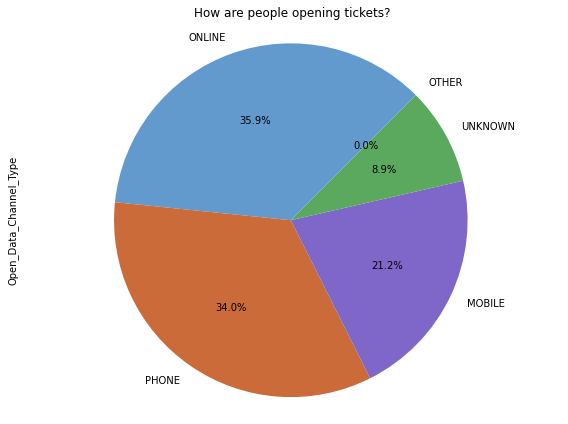

In [24]:
# How are people opening tickets?
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
df1['Open_Data_Channel_Type'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        startangle=45, shadow=False, colors = colors,
                        figsize = (8,6))
plt.axis('equal')
plt.title('How are people opening tickets?')
plt.tight_layout()
plt.show()

35.6% of the requests were submitted online.


## 2020 Call Spikes

I see a big spike in 1 day, what caused this?
> What are the top 5 dates for most complaints?




2020-08-04    18789
2020-08-05    15893
2020-07-05    15848
2020-07-04    15238
2020-06-20    14917
Name: created_dd_mm_yyy, dtype: int64


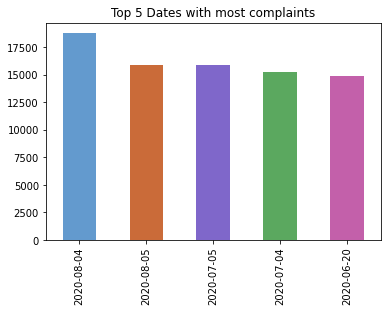

In [25]:
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
dfLine2 = dfLine.reset_index()
df1["created_dd_mm_yyy"]=df1.created_date.map(lambda x: x.strftime('%Y-%m-%d'))
print(df1.created_dd_mm_yyy.value_counts().nlargest(5))
df1.created_dd_mm_yyy.value_counts().nlargest(5).plot(kind = "bar", x= "Date", y= "Number of Complaints", title= "Top 5 Dates with most complaints", color= colors)


August 4th was the day New York was hit with tropical storm Isaias: 
https://www.ny1.com/nyc/all-boroughs/weather/2020/08/04/isaias-new-york-city-august-4

4th of July was also up there for more complaints



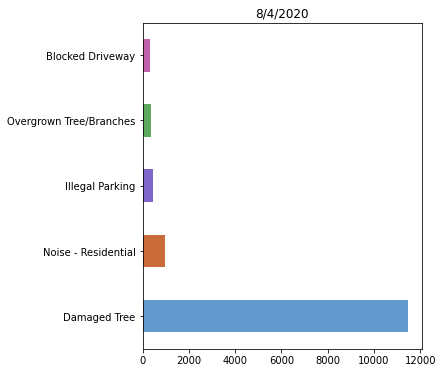

In [26]:
# What were the top 5 complaints on 8/4?
from matplotlib.pyplot import figure
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f']
#Storm
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-08-04").value_counts().nlargest(5).plot(kind='barh', title="8/4/2020", color=colors, figsize=(5,6))

The most common complaint type from 8/4 was "damaged trees" 

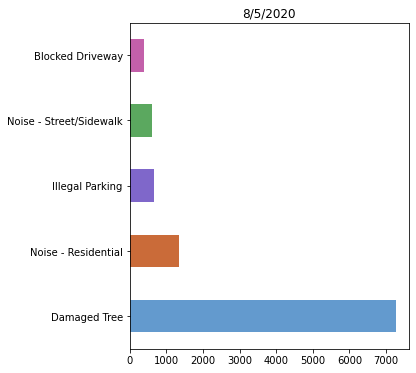

In [27]:
# What were the top 5 complaints on 8/5?
from matplotlib.pyplot import figure
colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f']
# Storm
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-08-05").value_counts().nlargest(5).plot(kind='barh', title="8/5/2020", color=colors, figsize=(5,6))

The most common complaint the next day (8/5)  was still Damaged tree 



Let's look at what time of day these calls were being called in

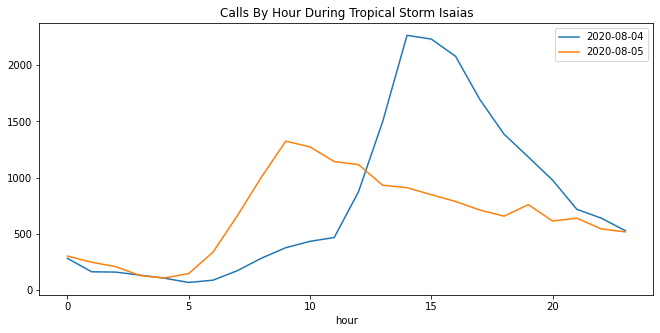

In [28]:
calls_over_time = df1.pivot_table(index="created_dd_mm_yyy", columns ="hour", values = "unique_key", aggfunc = "count")
calls_over_time.loc["2020-08-04"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 
calls_over_time.loc["2020-08-05"].plot(kind="line",x="hour", y="Number of calls",title="Calls By Hour During Tropical Storm Isaias",legend=True , figsize=(11,5)) 

You can see what time the storm hit on the 4th and what time people woke up on the 5th

Next, we will take a look at 7/4 and 7/5.

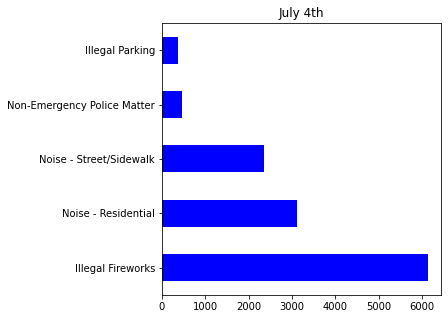

In [29]:
#4th of July
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-07-04").value_counts().nlargest(5).plot(kind='barh', title="July 4th", color="#0000FF",figsize=(5,5)) 

Fireworks on the 4th of July are typical, so this complaint makes sense. 

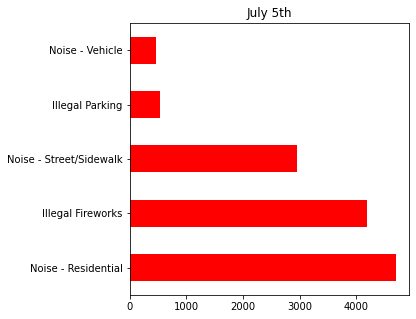

In [30]:
# What about July 5th?
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-07-05").value_counts().nlargest(5).plot(kind='barh', title="July 5th", color="#FF0000",figsize=(5,5)) 

Fourth of July parties that ran long (past-midnight)  would have been counted as occuring on 7/5


Text(0.5, 0, 'Hour')

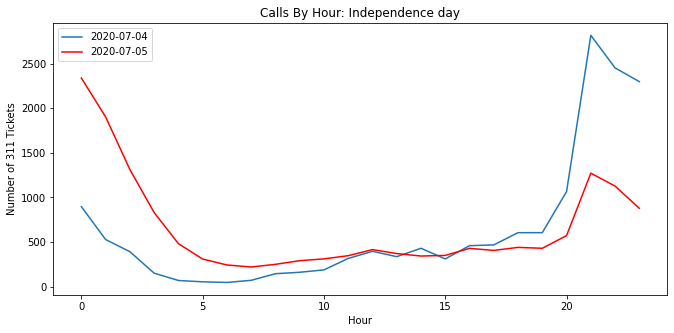

In [31]:
colors = "#FF0000","#0000FF"
calls_over_time.loc["2020-07-04"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 
calls_over_time.loc["2020-07-05"].plot(kind="line",x="hour", y="Number of calls",title="Calls By Hour: Independence day",legend=True ,color=colors, figsize=(11,5)) 
plt.ylabel('Number of 311 Tickets')
plt.xlabel('Hour')

Most calls during the night, opposite of what we saw during the storms. Fourth of July celebrations would typically start at night and continue into the early morning which is in line with the graph. 

As we can see from the above graph, calls spiked from the evening of 7/4 into the early morning of 7/5

The last day we will look at is 6/20

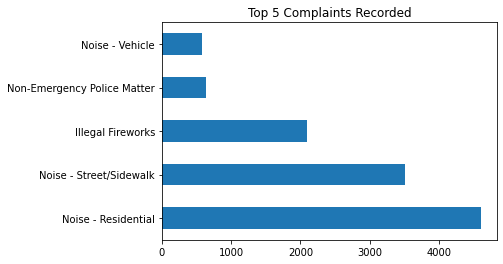

In [32]:
#Night after JuneTeenth, and Firework controversy
#https://gothamist.com/news/illegal-fireworks-soar-nyc-complaints-2020
df1.complaint_type.where(df1["created_dd_mm_yyy"] == "2020-06-20").value_counts().nlargest(5).plot(kind='barh', title="Top 5 Complaints Recorded")

6/20 was the day after Juneteeth, which was officially made a holiday in 2020. Celebratory events were planned for the event along with Black Lives Matter protests. 

We examined the pattern of these calls by hour. 

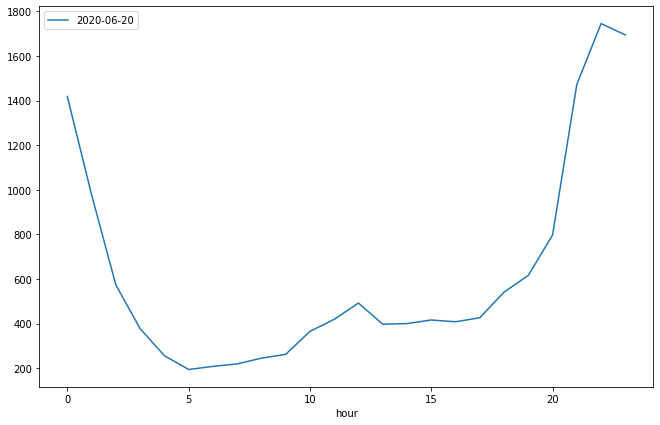

In [33]:
colors = "#FF0000","#0000FF"
calls_over_time.loc["2020-06-20"].plot(kind="line",x="hour", y="Number of calls",legend=True, figsize=(11,7)) 

These called peaked during the late night and early morning which is indiciative of night time complaints. 

## Complaint Type Visualizations

Now, we will look at the most frequent complaint types. 

In [34]:
# Top Complaints
df1.complaint_type.value_counts().nlargest(10)

Noise - Residential                    407044
Noise - Street/Sidewalk                206708
Illegal Parking                        194275
HEAT/HOT WATER                         164597
Blocked Driveway                       116751
Non-Emergency Police Matter             83936
Noise - Vehicle                         81191
UNSANITARY CONDITION                    61958
Damaged Tree                            58142
NonCompliance with Phased Reopening     51996
Name: complaint_type, dtype: int64

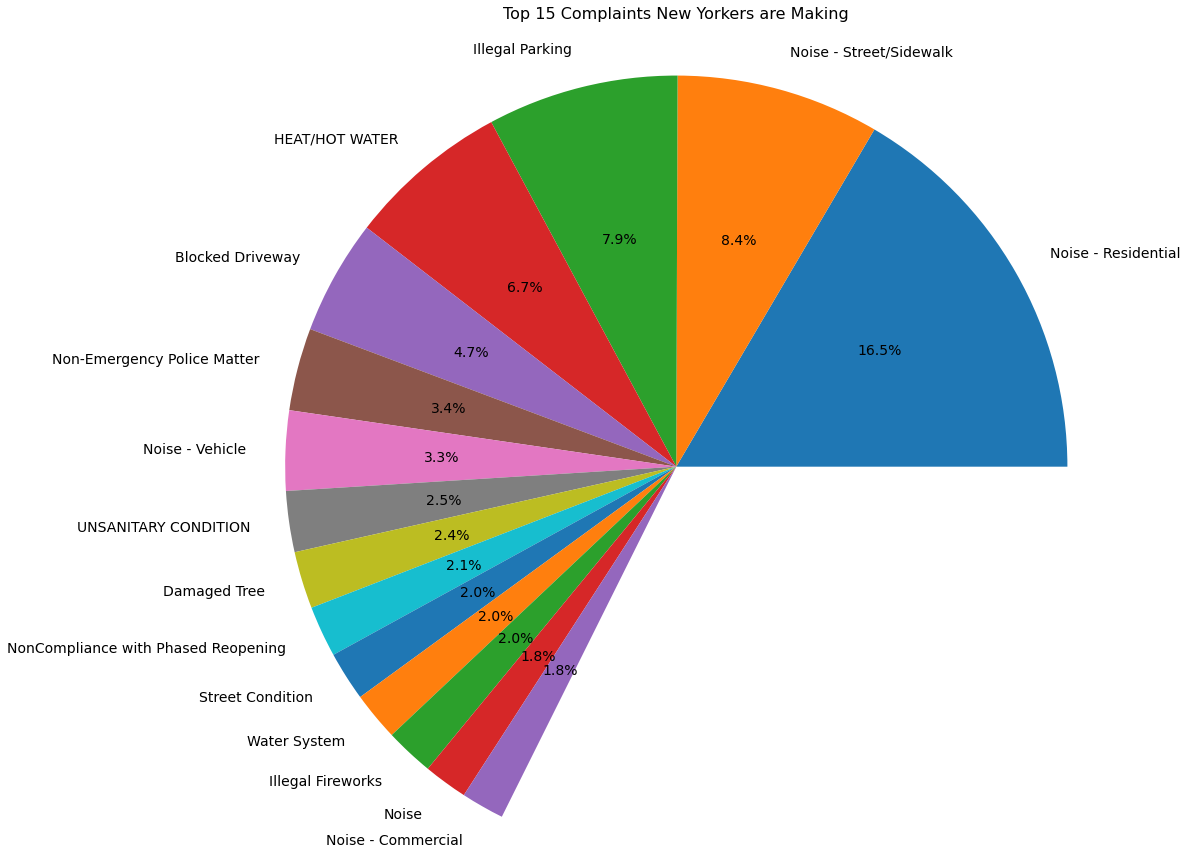

<Figure size 432x288 with 0 Axes>

In [35]:
#Figure showing the overall percents of the top 15 complaints 
import matplotlib.pyplot as plt
# Find percent of each complaint type
df_complaint = df1['complaint_type'].value_counts()[:15].sort_values(ascending=False) / len(df1)
sizes = df_complaint.values.tolist()
labels = df_complaint.index.values.tolist()

# Pie chart for complaint type
fig1, ax1 = plt.subplots(figsize=(15,15))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False,textprops={'fontsize': 14})
ax1.axis('equal')
plt.title("Top 15 Complaints New Yorkers are Making", fontdict={'fontsize':16}, loc="center", pad=20)
plt.show()

plt.savefig('image1.png')

The most common complaint types are for noise and illegal parking. Reports of these types of infractions may have risen due to the pandemic and the fact that more people were at home during business hours leading to more awareness of noise. 

CPU times: user 851 ms, sys: 5.75 ms, total: 857 ms
Wall time: 875 ms


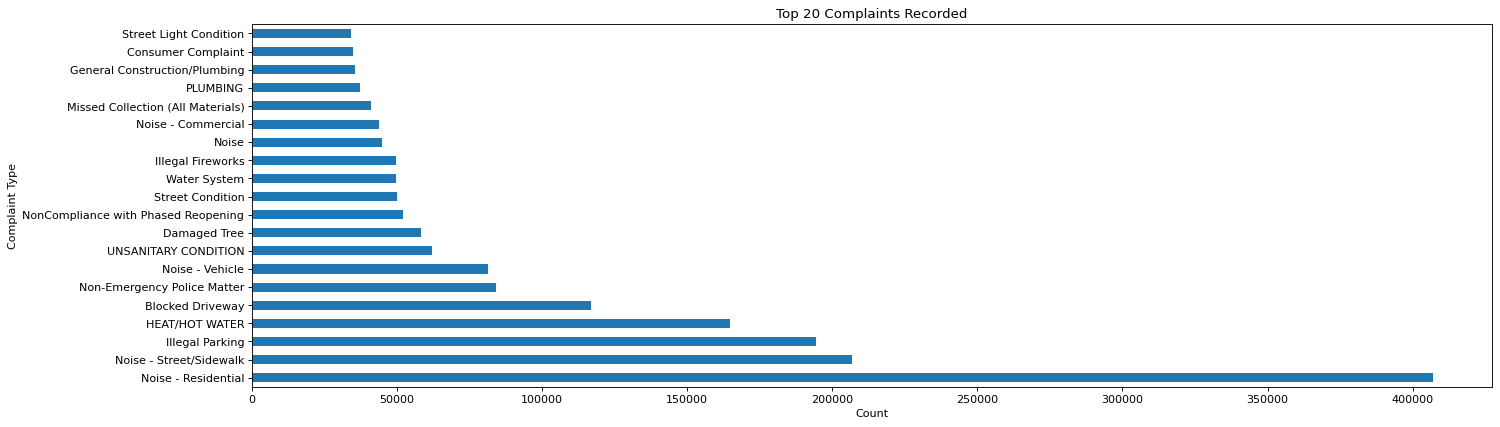

In [36]:
%%time
# Graph to see top complaint types
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
ax = df1.complaint_type.value_counts().nlargest(20).plot(kind='barh', title="Top 20 Complaints Recorded")
ax.set_xlabel("Count")
ax.set_ylabel("Complaint Type")

The below visual is the same idea as above just visualized as a word cloud


In [37]:
# WordCloud libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Group by complaint_type and count the frequency of unique keys
total = df1.groupby(["complaint_type"],as_index=False).agg({"unique_key": "count"})

# Dataframe for WordCloud, could change this to any number
top50 = total.nlargest(100,"unique_key")

Top 50 Complaints


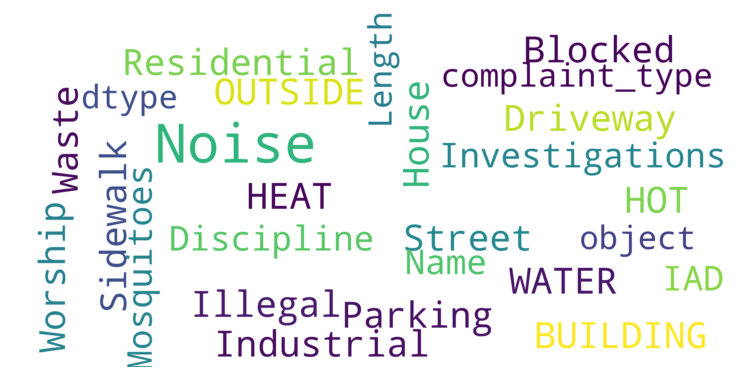

In [38]:
# Select text for WordCloud
text = top50["complaint_type"]
exclude = ["type", "dtype","Name","object"]
#stopwords = STOPWORDS.update(exclude)    # STOPWORDS is a of type Set     

wc = WordCloud(scale = 15,
  max_font_size=30,
    background_color = 'white')

wc.generate(str(text))

#S how figure
fig = plt.figure(figsize = (10,6))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
print("Top 50 Complaints")
plt.show()

Text(0, 0.5, 'Count of Complaints')

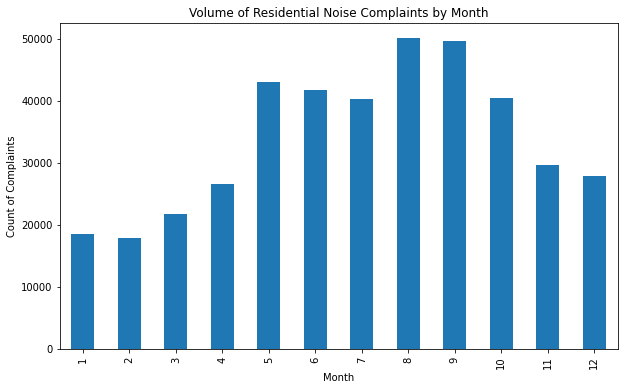

In [39]:
df2= df1[df1['complaint_type'] == 'Noise - Residential']
df2['month'].value_counts().sort_index().plot(kind = 'bar',figsize=(10,6), title = 'Volume of Residential Noise Complaints by Month')
plt.xlabel("Month")
plt.ylabel("Count of Complaints")

As you can see from the above, Residential Noise complaints are most common in the summer/warm weather months. 

In [40]:
# Find the average time to close complaints by complaint type 
df_complaint_timediff = df1[["agency", "complaint_type", "date_diff_hours"]]
df_complaint_timediff.head()
df_complaint_timediff = df_complaint_timediff.groupby(by=(["complaint_type"])).agg({"mean"}).reset_index()
df_complaint_timediff.tail(10)

,complaint_type,date_diff_hours
,,mean
145,Urinating in Public,1.957258
146,Vacant Lot,1071.689655
147,Vending,1.952538
148,Violation of Park Rules,25.533497
149,WATER LEAK,709.898465
150,Water Conservation,36.794355
151,Water Quality,373.684595
152,Water System,74.812166
153,Wood Pile Remaining,1320.900000


## Borough Visualizations

Looking at the data by borough:




In [41]:
# Neighborhood with most complaints:
df1.borough.value_counts().nlargest(10)

BROOKLYN         700666
BRONX            575044
QUEENS           567502
MANHATTAN        501320
STATEN ISLAND    103723
Unspecified       11956
Name: borough, dtype: int64

CPU times: user 557 ms, sys: 3.02 ms, total: 560 ms
Wall time: 557 ms


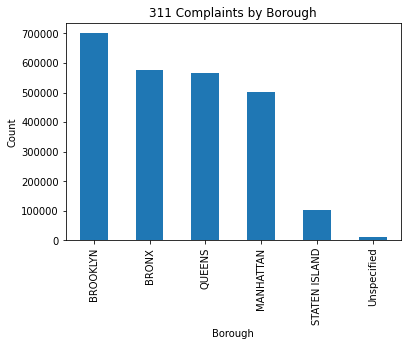

In [42]:
%%time
# Graph to see a value count by borough
ax1 = df1.borough.value_counts().plot(kind='bar', title= "311 Complaints by Borough")
ax1.set_xlabel("Borough")
ax1.set_ylabel("Count")

Brooklyn has the most complaints of any borough with an additional 150,000 complaints logged compared to the Bronx.

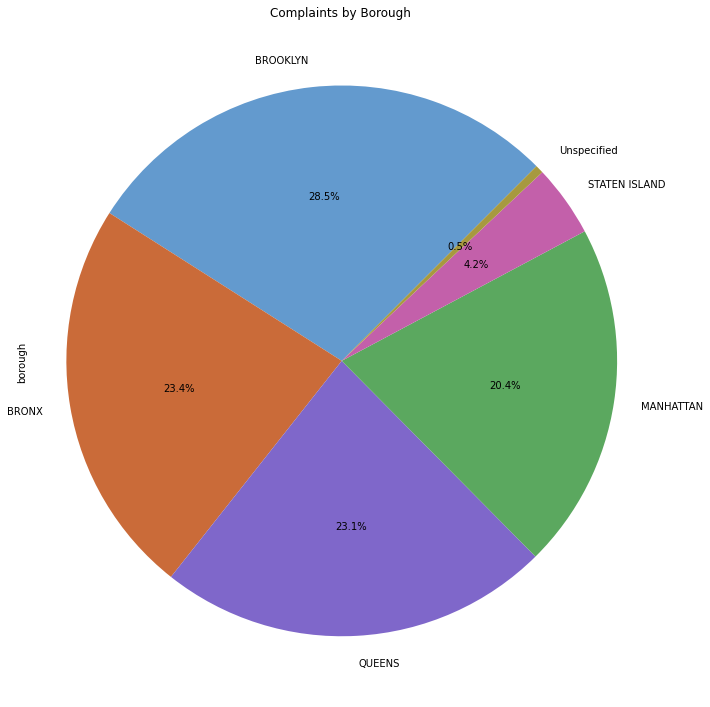

CPU times: user 706 ms, sys: 101 ms, total: 807 ms
Wall time: 691 ms


In [43]:
%%time
# Same idea as above just visualized differently
import matplotlib as mpl
from matplotlib import pyplot as plt

colors = ['#639ace','#ca6b39','#7f67ca','#5ba85f','#c360aa','#a7993f','#cc566a']
df1['borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        startangle=45, shadow=False, colors = colors,
                        figsize = (10,10))
plt.axis('equal')
plt.title('Complaints by Borough')
plt.tight_layout()
plt.show()

Next, we looked at the top 5 complaints by borough

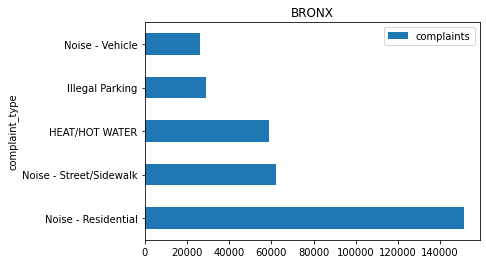

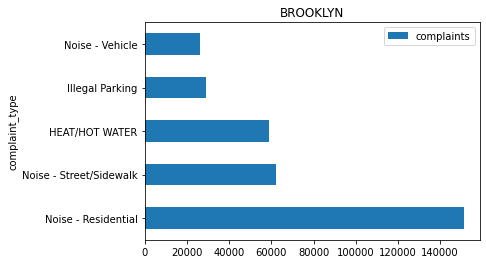

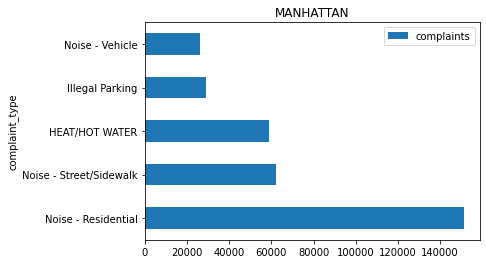

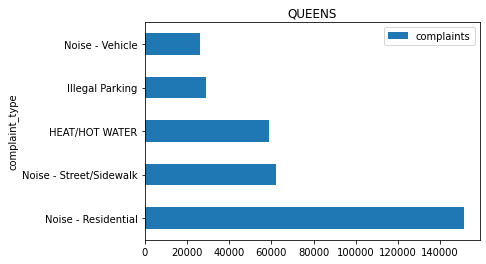

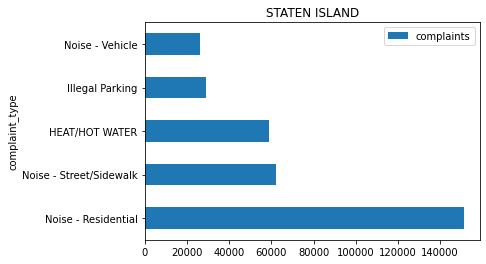

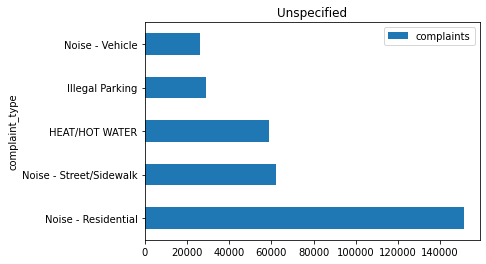

In [44]:
# View the above in graph form

# Top 5 most popular complaints in each borough
df_count = df1[['borough', 'complaint_type', "unique_key"]].groupby(['borough', 'complaint_type']).count().reset_index()
df_count.columns = ["borough", "complaint_type", "complaints"]
df_count2 = df_count.sort_values(by=["borough", "complaints"], ascending=[True, False])
df_count3 = df_count2.groupby(["borough"]).head(5)
df_count3

boroughs = df_count3.groupby(["borough"])
for b,group in boroughs:
    df_count3.head(5).plot(kind = "barh", x= "complaint_type", title=b)

All 5 bouroughs and unspecificed calls had the same top 5 complaints in the same order: Residential noise, Street/sidewalk noise, Heat/hot water, illegal parking, and vehicle noise.

Look at the top 10 complaints designated by borough 
> i.e. Which complaints by borough were most frequently called in 

Text(0, 0.5, 'Borough')

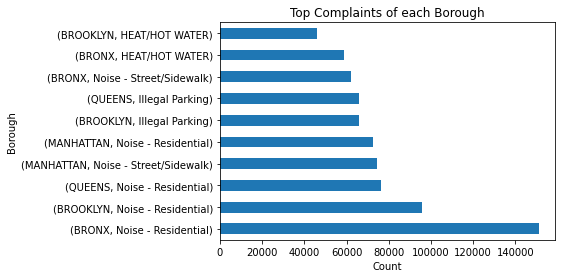

In [45]:
# Graph to see overall top compaints by borough
df4 = df1['complaint_type'].groupby(df1['borough']).value_counts()
df4.groupby(level=[0,1]).nlargest(10)
ax3 = df1.groupby('borough')['complaint_type'].value_counts().nlargest(10).plot(kind='barh', title="Top Complaints of each Borough")
ax3.set_xlabel("Count")
ax3.set_ylabel("Borough")

We can see that the most common complaint was residential noise complaints in the Bronx which is extremely large relative to other top complaints and the overall number of complaints orginiating in the Bronx. 

In [46]:
# Find the average time to close complaints by borough 
df_datediff = df1[[ "borough", "unique_key", "date_diff_hours"]]
df_datediff.head()
df_datediff = df_datediff.groupby(by=(["borough"])).agg({"mean"}).reset_index()
df_datediff

,borough,date_diff_hours
,,mean
0,BRONX,164.800819
1,BROOKLYN,189.939215
2,MANHATTAN,159.452300
3,QUEENS,252.020655
4,STATEN ISLAND,307.655259
5,Unspecified,609.031892


## Agency Visualizations

When is each agency receving the most calls during the day?

In [47]:
# Count of Agency
print('Count of agencies:', (df1['agency'].value_counts().count()))
print('List of agencies with total count of complaints logged:\n', (df1['agency'].value_counts()))

Count of agencies: 16
List of agencies with total count of complaints logged:
 NYPD             1269232
HPD               414075
DOT               168852
DEP               139746
DPR               108850
DSNY              103126
DOB                83885
MAYORS OFFICE      54405
DCA                34801
DOHMH              34701
DHS                23283
TLC                11263
EDC                10359
DFTA                2374
DOE                  831
DOITT                428
Name: agency, dtype: int64


[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Responding Agency by Hour')]

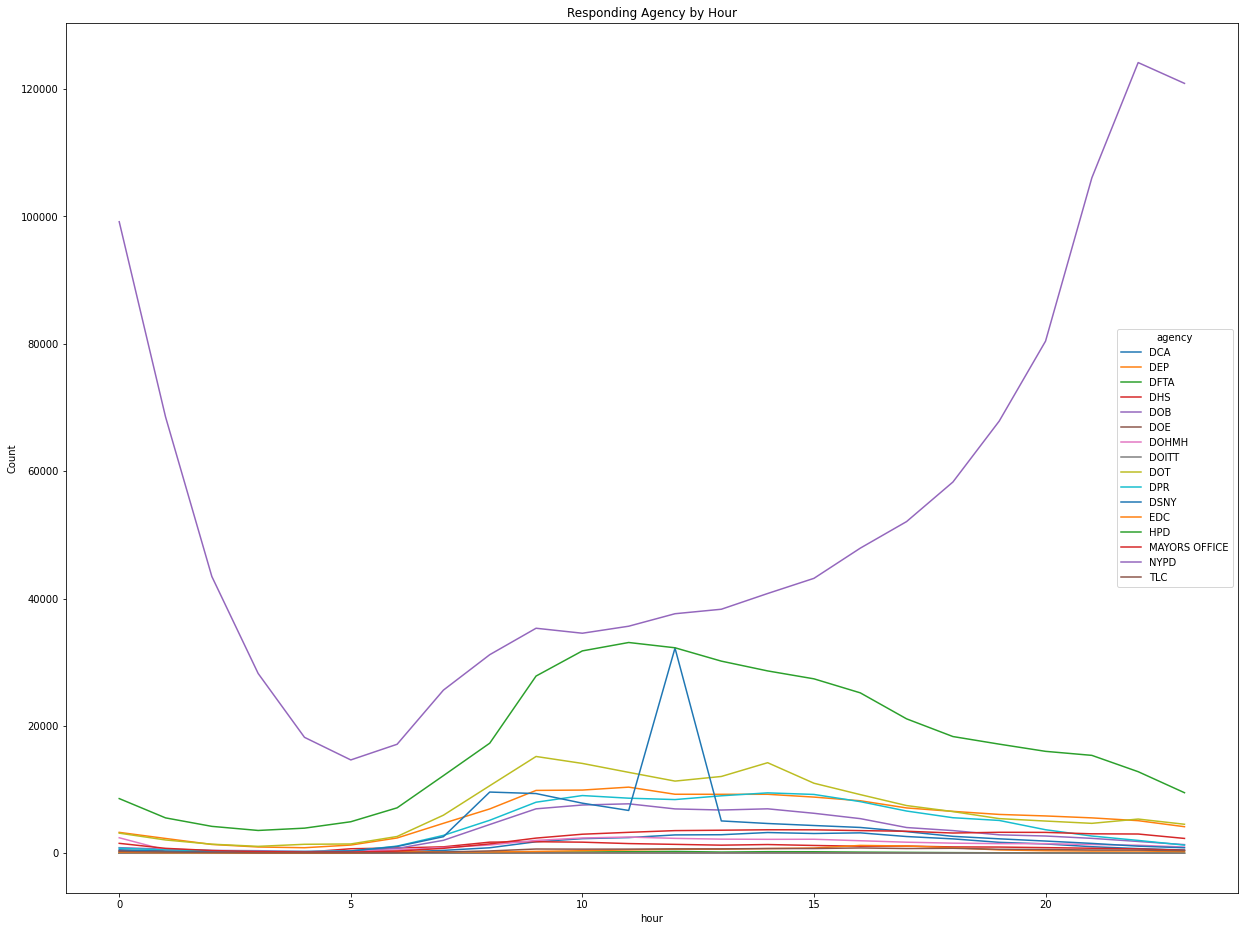

In [48]:
# Examine when each agency is busy during the day
agency = df1.pivot_table(index="hour", columns = "agency", values = "unique_key", aggfunc = "count")
agency.plot(kind="line", figsize=(21,16)).set(title="Responding Agency by Hour", ylabel = "Count")

As you can see from the above, NYPD issues spike at night. Other agencies that are likely open during normal business hours, see spikes during the day, particuraly at lunch when people may have time to report issues. 

Text(0, 0.5, 'Agency')

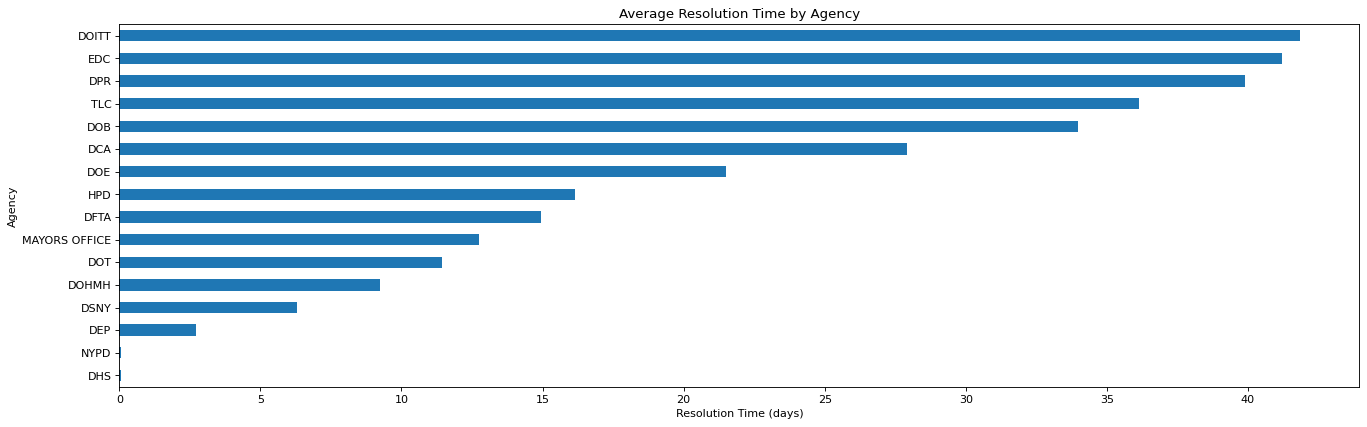

In [49]:
# Average response time by agency (in days)
df1['date_diff_days'] = (df1['closed_date'] - df1['created_date']).dt.days
mean_df = df1.groupby("agency")["date_diff_days"].mean().sort_values()

figure(figsize=(20, 6), dpi=80)
ax6=mean_df.plot(kind='barh',x='agency', title="Average Resolution Time by Agency")
ax6.set_xlabel("Resolution Time (days)")
ax6.set_ylabel("Agency")

In [50]:
# If we want to know specifics of resolution time (in days)
average_hour=df1[['agency','date_diff_days']]
average_hour=average_hour.groupby('agency').mean()
average_hour

,date_diff_days
agency,
DCA,27.919198
DEP,2.733939
DFTA,14.941449
DHS,0.044539
DOB,33.968695
DOE,21.486161
DOHMH,9.246247
DOITT,41.857477
DOT,11.451555


In [51]:
# What type of complaint does the Mayors office of Special Enforcement  handle?
mayor= df1[df1['agency'] == 'DOITT']
print("Top 10 Complaints the DOITT Responds to:")
mayor.complaint_type.value_counts().nlargest(10)

Top 10 Complaints the DOITT Responds to:


Public Payphone Complaint    285
LinkNYC                      143
Name: complaint_type, dtype: int64

Looks like in 2020 the Mayors Office of Special Enforcement primarily  focused on COVID and school re-openings

In [52]:
# Check to see if each complaint type is unique to one agency, i.e. does only one agency respond to Illegal parking?
df_res = df1[["complaint_type", "agency", "unique_key"]]
df_res = df_res[df_res ["complaint_type"]=="Illegal Parking"]
df_res = df_res.groupby(by=["agency"]).agg({"count"}).reset_index()
df_res.head()

,agency,complaint_type,unique_key
,,count,count
0,NYPD,194275,194275


We used the above code to see if multiple agencies tend to respond to the same complaint type or if each complaint type seems to pair with an agency. For the most part (a few exceptions) one specific agency will respond to a complaint type. For example, only the NYPD responds to Illegal Parking. We needed to confirm this before deciding what to use to test our model. 

## Descriptor Visualizations

Top 50 Descriptors


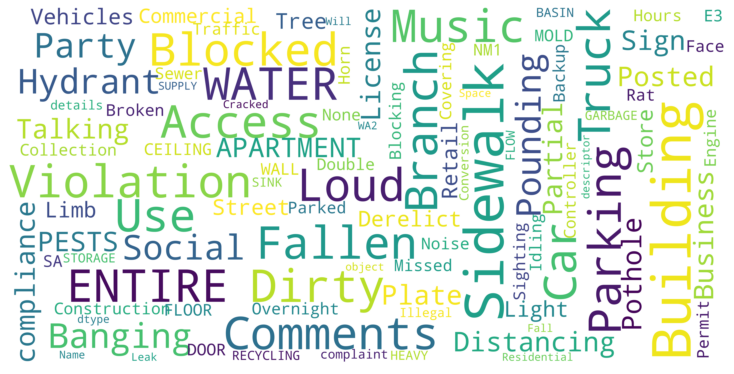

In [53]:
# Group by descriptor and count the frequency of unique keys
total2=df1.groupby(["descriptor"],as_index=False).agg({"unique_key": "count"})
total2.sample(5)

# Dataframe for WordCloud
top50_2=total2.nlargest(50,"unique_key")
top50_2.sample(5)

# Select text for WordCloud
text = top50_2["descriptor"]
exclude = ["type", "dtype","Name","object"]
#stopwords = STOPWORDS.update(exclude)    # STOPWORDS is a of type Set     

wc = WordCloud(scale = 15,
  max_font_size=30,
    background_color = 'white')

wc.generate(str(text))

#S how figure
fig = plt.figure(figsize = (10,6))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
print("Top 50 Descriptors")
plt.show()

<BarContainer object of 10 artists>

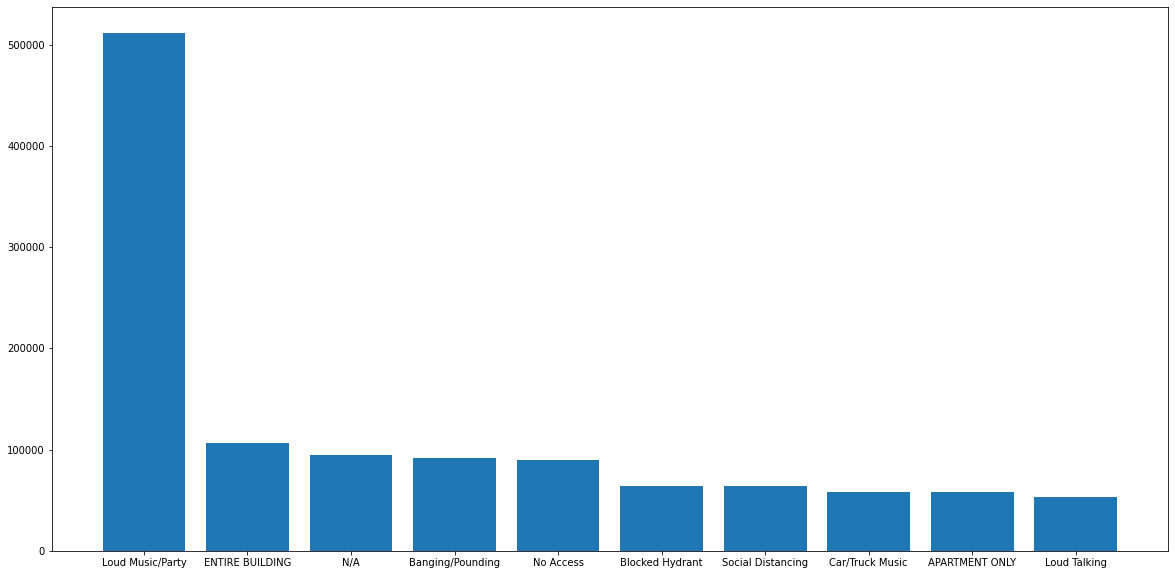

In [54]:
# Highest number of descriptors
plt.figure(figsize=[20,10])
plt.bar(df1['descriptor'].value_counts()[:10].index.tolist(), df1['descriptor'].value_counts()[:10].values)

[Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Number of Complaints by Descriptor and Borough')]

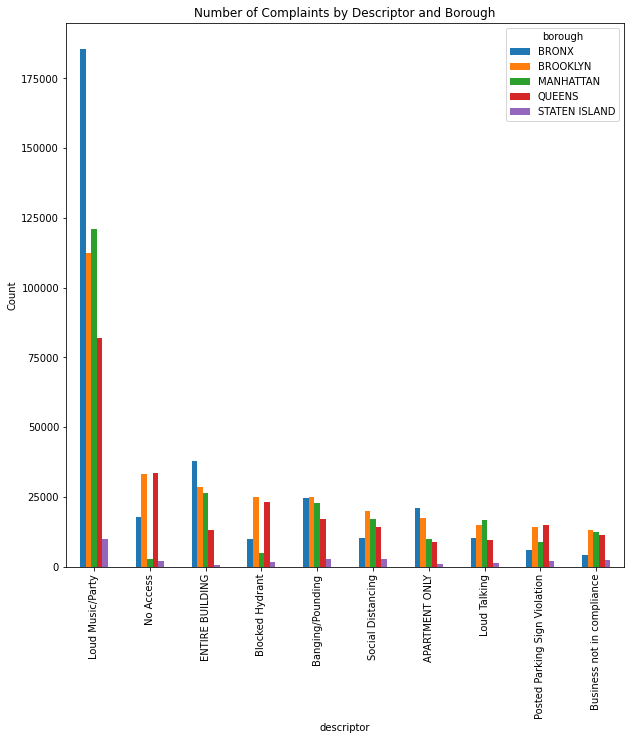

In [55]:
# Now look at those same descriptors by borough
descriptor_borough=df1[~df1.descriptor.str.contains("N/A")]
descriptor_borough = descriptor_borough.pivot_table(index="descriptor", columns = "borough", values = "unique_key", aggfunc = "count")
descriptor_borough = descriptor_borough.sort_values(by=['BROOKLYN'],ascending=False)
descriptor_borough.iloc[:10,:5].plot(kind="bar", figsize=(10,10)).set(title="Number of Complaints by Descriptor and Borough", ylabel = "Count")

# Source for colorful graphic:
# https://towardsdatascience.com/has-quarantine-made-you-hate-your-loud-neighbors-these-charts-certainly-imply-it-c760e999a04b

# ARIMA Modeling


## Intro


*   ARIMA, short for "**AutoRegressive Integrated Moving Average**", is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values

*   An ARIMA model is one where the time series was *differenced at least once* to make it stationary and you combine the AR and the MA terms

> > > Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

*   An ARIMA model is characterized by 3 terms or parameters: p, d, q
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary

*   The objective, is to identify the values of p, d and q.

Code examples and ARIMA info used from the following links:

*   https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
*   https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values.
*   https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b



Text(0.5, 0, 'Date')

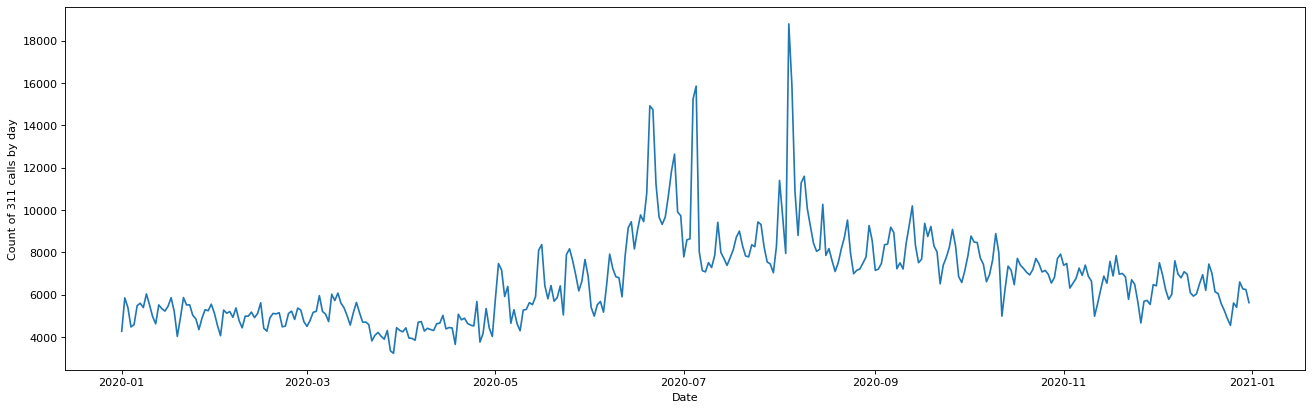

In [56]:
# Before we dive in to ARIMA modeling, let's remember the visualization from above, the number of 311 calls made per day in 2020.
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)
dfLine2 = dfLine.reset_index()

dfLine = df1['month'].groupby(df1.created_date.dt.date).count()
#dfLine2 = dfLine.reset_index(name='Count')

ax = dfLine.plot.line()
ax.set_ylabel("Count of 311 calls by day")
ax.set_xlabel("Date")

In [57]:
dfLine2

,created_date,month
0,2020-01-01,4270
1,2020-01-02,5849
2,2020-01-03,5395
3,2020-01-04,4476
4,2020-01-05,4585
...,...,...
361,2020-12-27,5404
362,2020-12-28,6600
363,2020-12-29,6274
364,2020-12-30,6241


In [58]:
dfLine2.columns

Index(['created_date', 'month'], dtype='object')

## Augmented Dickey-Fuller Test and D parameter

First we will look at the d parameter :

*   The first step to building an ARIMA model is to make the time series stationary
*   To check if the series is stationary we use the Augmented Dickey-Fuller Test
*   For an ARIMA model, you need differencing only if the series is non-stationary. Otherwise, no differencing is needed and d=0.
*   If **p-Value > 0.05 we go ahead with finding the order of differencing**







In [59]:
# What p-value are we starting off with?
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(dfLine)
print('p-value: %f' % result[1])

p-value: 0.346121


Since P-value is very high and greater than the significance level (.05), let’s difference the series and see what the autocorrelation plot looks like.


In [60]:
dfLine2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   created_date  366 non-null    object
 1   month         366 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


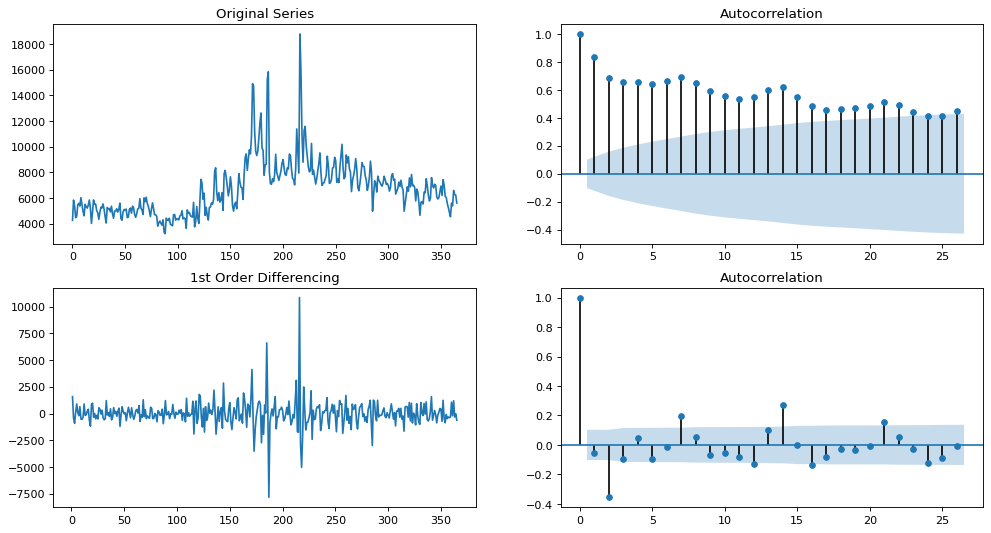

p-value: 0.000000


In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log

plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':80})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(dfLine2.month); axes[0, 0].set_title('Original Series')
plot_acf(dfLine2.month, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dfLine2.month.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dfLine2.month.diff().dropna(), ax=axes[1, 1])

plt.show()

result = adfuller(dfLine2.month.diff().dropna())
print('p-value: %f' % result[1])

1st level differencing achieves a p-value of 0, and an autocorrelation graph that stays relatively within the boundaries. *However*, we can see that every 7 lags goes outside of the boundary, **showing a weekly seasonality** in the data. We need to implement **SARIMAX** to take care of that.

## SARIMA and Accounting for Seasonality

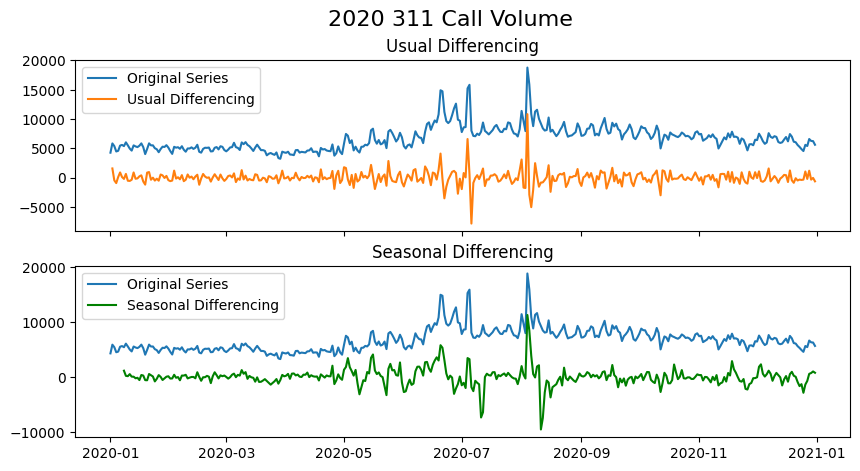

In [62]:
# Comparing usual vs. seasonal differencing 
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(dfLine[:], label='Original Series')
axes[0].plot(dfLine[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasional Differencing
axes[1].plot(dfLine[:], label='Original Series')
axes[1].plot(dfLine[:].diff(7), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('2020 311 Call Volume', fontsize=16)
plt.show()

Because we could see clear weekly trends in our auto correlation plot on the previous slide, we needed to account for seasonality. 

As you can see, the seasonal spikes are intact after applying usual differencing (lag 1) vs. seasonal differencing trends are more in line 

In [63]:
from statsmodels.tsa.arima_model import ARIMA
# Warnings for outdated ARIMA model, but we need this version to match what we have
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Automatic ARIMA model to find optimal hyperparameters for SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(dfLine, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p of 2
                      m=7,              # Weekly seasonality, so set 7 here
                      seasonal=True,    # Weekly seasonality, so set true
                      d = None,         # Let model determine the differencing with auto-regression and moving average being tuned
                      start_P=0,        # start seasonal p at 0
                      seasonal_test = 'ocsb',  # allow model to determine if the data is seasonal and fit the D based on this test
                      D = None,              # Weekly seasonality, so set None here to allow model to auto determine best value
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6156.994, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6221.630, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6210.341, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6211.283, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6219.635, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6166.538, Time=0.37 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6134.892, Time=1.23 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=6151.601, Time=0.96 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=6143.526, Time=1.89 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=6145.113, Time=2.26 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=6140.124, Time=1.77 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=6136.162, Time=1.65 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=6146.337, Time=2.50 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=6182.150, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept

We are told a model of **SARIMA(3,1,1)(1,0,1)[7]** is best

3,1,1 makes sense with our first visualizations because 3 p (AR) fits with spike we see in the autocorrelaltion plot of the 1'st level differencing, 1 I (d) gave us a p-score of 0, and 1 MA (q) would take more visualizations but fits with the understanding that recent events matter more for the data. 

(1,0,1,7) is the calculated ARIMA hyperparameters p,d,q for the season of 7 days.

Next, we put throw these values into the model and look at some visualizations.

(The hyperparameters chosen have changed between runtimes before, if this shows a different result for optimal for your runtime, know that the model has the above hyperparameters hard coded for the next cells)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Figure(800x560)


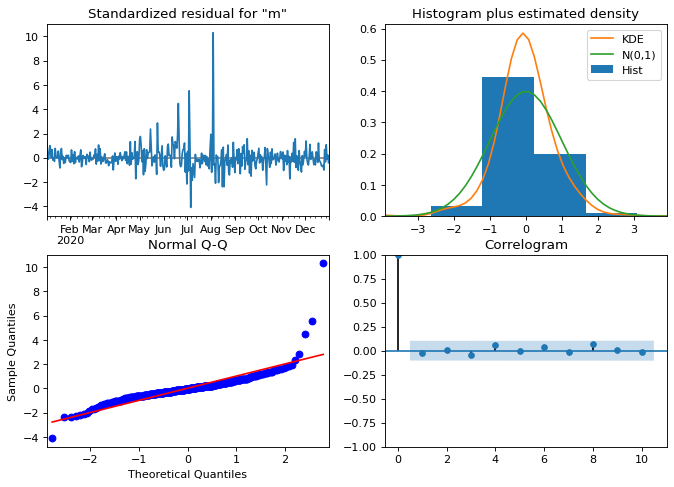

In [64]:
# Use suggested model, but use MA of 2 instead of 3
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfLine, order=(3,1,1), seasonal_order = (1,0,1,7)).fit()

print(model.plot_diagnostics(figsize=(10,7)))

**Top left:** The residual errors seem to fluctuate around a mean of zero and with the exception of a few spikes, have a reasonably uniform variance.

**Top Right:** The density plot suggest a fairly normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it's not perfect as the spike from the storm seems to be throwing off some of our values still (shown with a 'heavy tail' q-q plot). The correlation is doing well however.

**Time to forecast.**

## Forecasting

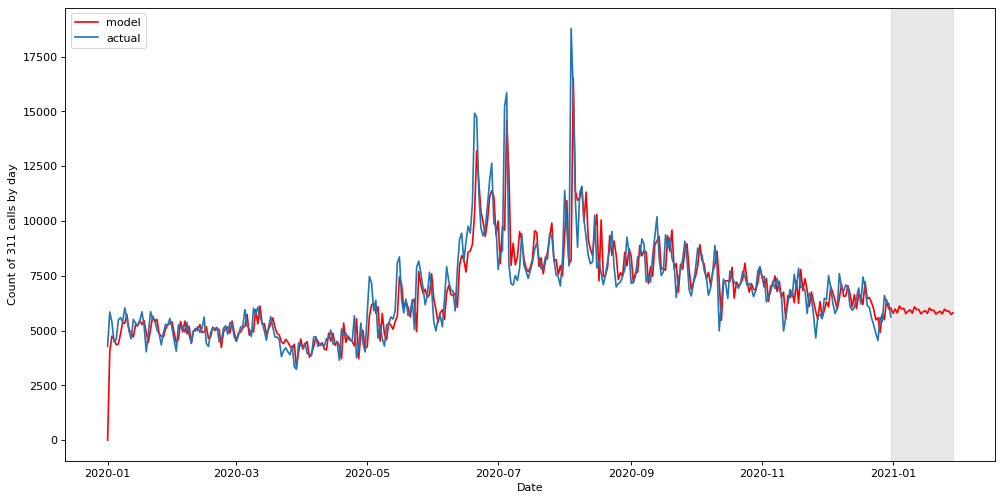

In [65]:
# Values from model to be graphed
testdata = model.fittedvalues

# Forecast the next 4 weeks
forecast = model.predict(start=testdata.shape[0], end=testdata.shape[0] + 28)
forecast = testdata.append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(testdata.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(dfLine, label='actual')
plt.xlabel("Date")
plt.ylabel("Count of 311 calls by day")
plt.legend()
plt.show()

Lets calculate the **Root Mean Square Error** (RMSE) of these 2 lines, but before that, we need to deal with the NaN values at the start of forecast programatically.

In [66]:
# Calculate shape
pre = forecast.shape[0]
# Drop the leading nulls
forecast = forecast.dropna()
# Shape after drop
post = forecast.shape[0]
# Difference the 2
diff = post - pre

In [67]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# Root mean square error of the 2 lines
rmse = sqrt(mean_squared_error(forecast[diff:dfLine.shape[0]],dfLine[diff:]))
print('RMSE is:', rmse)

from sklearn.metrics import r2_score

# R2 of the 2 lines, closer we are to 1 the better.
r2 = r2_score(forecast[diff:dfLine.shape[0]],dfLine[diff:])
print('R2 Score is:', r2)

RMSE is: 1053.2339134839253
R2 Score is: 0.7109210204328811


R2 of 0.711 is fairly high, especially for a forecast. This score is a model trained on itself though, the red piece with a grey bar is a forecast for no data

# Additional Models



### **Random Forest**

In [83]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# X values, what are we using to predict?
X = df1[['agency', 'complaint_type', 'borough']].copy()

le = preprocessing.LabelEncoder()
X_enc = X.apply(le.fit_transform)

#Y values, what are we trying to predict?
y = df1['date_diff_hours']

#80 20 split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=1)

In [86]:
# Create a Gaussian Classifier
rf=RandomForestRegressor(n_estimators=10, max_depth = 3)

rf.fit(X_train,y_train)

y_RF_pred=rf.predict(X_test)

print("r2 score:",r2_score(y_test, y_RF_pred))

r2 score: 0.13159465172270424


Random Forest didn't do nearly as well as ARIMA, but not many other models exist that would give us an adequate runtime with the large volume of data we have

# Conclusion

I found that the ARIMA model had the best performance at predicting call volume with an R2 value of 0.71. However, the random forest model was not effective in prediciting the time until the complaints were closed with R2 values of .13.  

Overall, this data does not lend itself to modeling due to the nature of 311 calls. I found that the data is unpredictable and that stochastic events influence call volume which in turn may impact response time. Examples of these events we found include extreme weather (Tropical storm Isaias), pandemic conditions, utility outages, and protests. Furthermore, the features that I selected did not appear to have much predictive value despite the fact that many complaint types were handled exclusively by one or two departments. 

To expand on this for future research, additional datasets could be integrated to model potential stochastic events and how these impact call volumes. For example, the integration of weather pattern data could assist in tagging calls in response to extreme weather. 